In [2]:
%pip install torchinfo


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import numpy as np
import torch.nn as nn
from torchinfo import summary
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier


In [2]:
path = './MURA-v1.1/'
train_image_paths_csv = "train_image_paths.csv"
df_train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
df_train_images_paths.columns = ['image_path']

In [3]:
df_train_images_paths['label'] = df_train_images_paths['image_path'].map(lambda x: 'positive' if 'positive' in x else 'negative')
df_train_images_paths['category'] = df_train_images_paths['image_path'].apply(lambda x: x.split('/')[2])
#df_train_images_paths['patientId'] = df_train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

In [4]:
valid_image_paths_csv = "valid_image_paths.csv"
df_valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
df_valid_data_paths.columns = ['image_path']

In [5]:
df_valid_data_paths['label'] = df_valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
df_valid_data_paths['category']  = df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])
#df_valid_data_paths['dir'] =  df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
#df_valid_data_paths['patientId']  = df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

In [ ]:
df_train_images_paths.head()

In [ ]:
df_valid_data_paths.head()

In [11]:
def splitByRatio(dataframe,n_samples = int):
    balanced_df = pd.DataFrame()
    for category in dataframe["category"].unique():
        # Filter the DataFrame by category
        sub_df = dataframe[dataframe["category"] == category]

        # Filter positive and negative samples
        pos_samples = sub_df[sub_df["label"] == 'positive'].sample(n=n_samples)
        neg_samples = sub_df[sub_df["label"] == 'negative'].sample(n=n_samples)

        # Concatenate positive and negative samples
        balanced_sub_df = pd.concat([pos_samples, neg_samples])

        # Add to the final balanced DataFrame
        balanced_df = pd.concat([balanced_df, balanced_sub_df])

    return balanced_df

In [15]:
train_balanced = splitByRatio(df_train_images_paths,500)
train_balanced = train_balanced.reset_index(drop=True)


In [16]:
valid_balanced = splitByRatio(df_valid_data_paths,100)
valid_balanced = valid_balanced.reset_index(drop=True)


In [19]:
filtered_df = df_train_images_paths.loc[df_train_images_paths['label'] == 'negative']
filtered_df = filtered_df.reset_index(drop=True)


In [ ]:
filtered_df.head()

In [37]:
df_train_images_paths["label"] = df_train_images_paths["label"].replace({'positive': 1, 'negative': 0})


In [17]:
train_balanced["label"] = train_balanced["label"].replace({'positive': 1, 'negative': 0})


In [38]:
df_valid_data_paths["label"] = df_valid_data_paths["label"].replace({'positive': 1, 'negative': 0})


In [18]:
valid_balanced["label"] = valid_balanced["label"].replace({'positive': 1, 'negative': 0})


# Feautre extraction

In [24]:
%matplotlib inline

In [ ]:
%pip install scikit-image

## HOG

In [20]:
from skimage.feature import hog
from skimage.feature import canny
from skimage.filters import prewitt
from skimage.filters import gabor
from skimage.filters import sobel
from skimage.filters import butterworth
from skimage.filters import gaussian
from skimage.filters import hessian
from skimage.filters import median
from skimage import exposure




import random

In [ ]:
idx = random.randint(0, filtered_df.__len__())
img = plt.imread(filtered_df['image_path'][idx])
plt.imshow(img)
img.shape

In [ ]:
equalized_img = exposure.equalize_adapthist(img, clip_limit=0.02)
plt.imshow(equalized_img)

In [ ]:
fd, hog_image = hog(equalized_img, orientations=9, pixels_per_cell=(2, 2),
                    cells_per_block=(1, 1), visualize=True)
plt.imshow(hog_image)
fd.shape

## Prewitt

In [ ]:
edge_prewitt = prewitt(equalized_img)
plt.imshow(edge_prewitt)

## Gabor Filter


In [ ]:
filt_real, gabor_filter = gabor(equalized_img,frequency=0.1)

plt.imshow(gabor_filter)

## Canny

In [ ]:
Canny_edge = canny(equalized_img,sigma=0)
plt.imshow(Canny_edge)

## Sobel


In [ ]:
sobel_edge = sobel(equalized_img)
plt.imshow(sobel_edge)

In [ ]:
butterworth_img = butterworth(equalized_img)
plt.imshow(butterworth_img)

In [ ]:
gaussian_img = gaussian(equalized_img)
plt.imshow(gaussian_img)

In [ ]:
hessian_img = hessian(equalized_img)
plt.imshow(img)

In [ ]:
laplace_img = median(equalized_img)
plt.imshow(img)

In [48]:
from torch.utils.data import Dataset
from skimage import img_as_ubyte
from skimage.color import rgb2gray
class MuraDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, device='cpu'):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        
        # Convert PIL Image to numpy array
        image_np = np.array(image)
        
        image_gray = rgb2gray(image_np)
        
        # Apply adaptive histogram equalization
        image_gray = exposure.equalize_adapthist(image_gray, clip_limit=0.02)

        
        # Apply Butterworth filter
        image_butterworth = butterworth(image_gray)

        
        # Apply Gaussian filter
        image_gaussian = gaussian(image_gray)
        
        # Combine the two images into one (stack them along the last axis)
        # Create a 3 channel image from the butterworth and gaussian filtered images
        image_combined = np.stack([image_butterworth, image_gaussian, image_gray], axis=-1)
        
        image_combined = (image_combined - np.min(image_combined)) / (np.max(image_combined) - np.min(image_combined))
        
        # Convert to 8-bit image for PIL
        image_combined = img_as_ubyte(image_combined)
        
        # Convert numpy array back to PIL Image
        image = Image.fromarray(image_combined)
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        image = image.to(self.device)
        
        label = torch.tensor(label).to(self.device)

        return image, label


In [21]:
df_valid_data_paths.count()

image_path    3197
label         3197
category      3197
dtype: int64

In [22]:
df_train_images_paths.count()

image_path    36808
label         36808
category      36808
dtype: int64

In [49]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2

batchsize = 8
transform = transforms.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

val_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

Mura_transform = MuraDataset(df_train_images_paths["image_path"], df_train_images_paths["label"], transform=transform,device='cuda')
train_loader = DataLoader(Mura_transform, batch_size=batchsize, shuffle=True)
Mura_transform_valid = MuraDataset(df_valid_data_paths["image_path"], df_valid_data_paths["label"], transform=val_transform,device='cuda')
valid_loader = DataLoader(Mura_transform_valid, batch_size=batchsize)



c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


Feature batch shape: torch.Size([8, 3, 224, 224])
Labels batch shape: torch.Size([8])


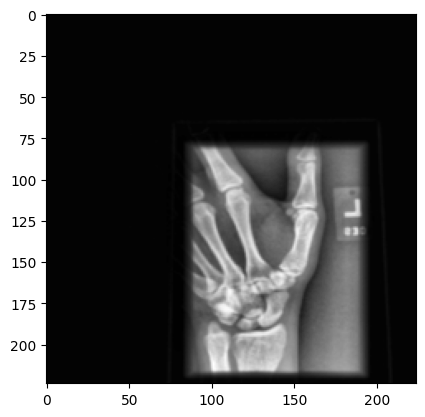

Label: 1


In [42]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Select a single image from the batch.
img = train_features[0]

# Select one channel (e.g., the first channel).
img_channel1 = img[1].cpu().numpy()

# Display the selected channel.
plt.imshow(img_channel1, cmap="gray")
plt.show()

# Alternatively, you can display the second channel
# img_channel2 = img[1].cpu().numpy()
# plt.imshow(img_channel2, cmap="gray")
# plt.show()

label = train_labels[0]
print(f"Label: {label}")


In [ ]:
# %pip install timm

In [42]:
import timm
vit_model = timm.create_model(model_name='vit_base_patch16_224_in21k',num_classes = 2)

c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
# vit_model.to(device)

In [62]:
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-7)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)


In [46]:
# num_epochs = 3

# for epoch in range(num_epochs):
#     vit_model.train()
#     total_loss = 0.0
#     correct = 0  # To keep track of correct predictions
#     total = 0  # To keep track of total predictions

#     batch_accuracies = []  # To store batch accuracies for the epoch

#     for batch_idx, (images, labels) in enumerate(train_loader):
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = vit_model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#         # Calculate accuracy
#         _, predicted = outputs.max(1)  # Get the index of the max log-probability
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()

#         # Print loss and accuracy for every 584 batches
#         if (batch_idx + 1) % 32 == 0:
#             batch_accuracy = 100. * correct / total
#             batch_accuracies.append(batch_accuracy)  # Store the batch accuracy
#             print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Batch Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy:.2f}%")
#     scheduler.step()
#     avg_loss = total_loss / len(train_loader)
#     epoch_accuracy = 100. * correct / total  # Convert to percentage

#     # Calculate the average of batch accuracies for the epoch
#     avg_batch_accuracy = sum(batch_accuracies) / len(batch_accuracies) if batch_accuracies else 0.0

#     print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Epoch Accuracy: {epoch_accuracy:.2f}%, Average Batch Accuracy: {avg_batch_accuracy:.2f}%")


In [47]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Switch the model to evaluation mode
# vit_model.eval()

# # Initialize lists to store all true labels and all predictions
# all_labels = []
# all_predictions = []

# # Disabling gradient calculation
# with torch.no_grad():
#     for batch_idx, (images, labels) in enumerate(valid_loader):
#         images, labels = images.to(device), labels.to(device)

#         # Forward pass
#         outputs = vit_model(images)

#         # Get predictions
#         _, predicted = outputs.max(1)

#         # Store predictions and true labels for later calculation of metrics
#         all_predictions.extend(predicted.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

#         # Print status for every 175 batches (or another number if you prefer)
#         if (batch_idx + 1) % 175 == 0:
#             print(f"Test Batch [{batch_idx+1}/{len(valid_loader)}] Processed")

# # Compute metrics
# accuracy = accuracy_score(all_labels, all_predictions)
# precision = precision_score(all_labels, all_predictions, average='weighted')  # Using weighted average if you have class imbalance
# recall = recall_score(all_labels, all_predictions, average='weighted')  # Using weighted average if you have class imbalance
# f1 = f1_score(all_labels, all_predictions, average='weighted')  # Using weighted average if you have class imbalance


# print(f"Test Accuracy: {accuracy:.4f}")
# print(f"Test Precision: {precision:.4f}")
# print(f"Test Recall: {recall:.4f}")
# print(f"Test F1-Score: {f1:.4f}")


In [48]:
# import torch
# save_path = './Vit_mura_phase_3.pth'
# torch.save(vit_model,save_path)

# Swin Transformer

In [28]:
from transformers import SwinForImageClassification

In [29]:
model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

# Removing the last layer and adding only 2 output instead of 1000

In [30]:
model.classifier = nn.Linear(in_features=768, out_features=2)
model

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [ ]:
# layers = list(swin_model.children())[:-1]
# layers.append(nn.Linear(in_features=768,out_features=2))
# model = nn.Sequential(*layers)
summary(model, input_size=(8, 3, 224, 224))


In [ ]:
model.to(device)

# Grid search to find the best learning rate

In [43]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [33]:
# learning_rates = [0.001, 0.0001,0.00001,0.000001]
# best_lr = None
# best_accuracy = 0.0

# for lr in learning_rates:
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     # Initialize and train Swin Transformer with learning rate = lr
#     # ...
#     # Validate the model
#     val_accuracy = validate_model(model, val_data)
#     if val_accuracy > best_accuracy:
#         best_accuracy = val_accuracy
#         best_lr = lr
        


In [45]:
num_epochs = 7

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0  # To keep track of correct predictions
    total = 0  # To keep track of total predictions

    batch_accuracies = []  # To store batch accuracies for the epoch

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        logits = outputs.logits  # Extract the logits
        loss = criterion(logits, labels) 
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        
        _, predicted = logits.max(1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print loss and accuracy for every 200 batches
        if (batch_idx + 1) % 200 == 0:
            batch_accuracy = 100. * correct / total
            batch_accuracies.append(batch_accuracy)  # Store the batch accuracy
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Batch Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy:.2f}%")
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total  # Convert to percentage

    # Calculate the average of batch accuracies for the epoch
    avg_batch_accuracy = sum(batch_accuracies) / len(batch_accuracies) if batch_accuracies else 0.0

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Epoch Accuracy: {epoch_accuracy:.2f}%, Average Batch Accuracy: {avg_batch_accuracy:.2f}%")


Epoch [1/7], Batch [200/4601], Batch Loss: 0.6355, Batch Accuracy: 71.94%
Epoch [1/7], Batch [400/4601], Batch Loss: 0.3625, Batch Accuracy: 72.94%
Epoch [1/7], Batch [600/4601], Batch Loss: 0.2558, Batch Accuracy: 73.31%
Epoch [1/7], Batch [800/4601], Batch Loss: 0.5197, Batch Accuracy: 73.59%
Epoch [1/7], Batch [1000/4601], Batch Loss: 0.5046, Batch Accuracy: 73.99%
Epoch [1/7], Batch [1200/4601], Batch Loss: 0.5219, Batch Accuracy: 74.29%
Epoch [1/7], Batch [1400/4601], Batch Loss: 0.2487, Batch Accuracy: 74.71%
Epoch [1/7], Batch [1600/4601], Batch Loss: 0.6161, Batch Accuracy: 74.84%
Epoch [1/7], Batch [1800/4601], Batch Loss: 0.3205, Batch Accuracy: 75.17%
Epoch [1/7], Batch [2000/4601], Batch Loss: 0.3340, Batch Accuracy: 75.25%
Epoch [1/7], Batch [2200/4601], Batch Loss: 0.3587, Batch Accuracy: 75.41%
Epoch [1/7], Batch [2400/4601], Batch Loss: 0.3201, Batch Accuracy: 75.61%
Epoch [1/7], Batch [2600/4601], Batch Loss: 0.8179, Batch Accuracy: 75.72%
Epoch [1/7], Batch [2800/4601

In [ ]:
len(valid_loader)

100

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Switch the model to evaluation mode
model.eval()

# Initialize lists to store all true labels and all predictions
all_labels = []
all_predictions = []    

# Disabling gradient calculation
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(valid_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)  
        logits = outputs.logits

        # Get predictions
        _, predicted = logits.max(1)

        # Store predictions and true labels for later calculation of metrics
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Print status for every 50 batches (or another number if you prefer)
        if (batch_idx + 1) % 100 == 0:
            print(f"Test Batch [{batch_idx+1}/{len(valid_loader)}] Processed")


# Compute metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)  # Using weighted average if you have class imbalance
recall = recall_score(all_labels, all_predictions)  # Using weighted average if you have class imbalance
f1 = f1_score(all_labels, all_predictions)  # Using weighted average if you have class imbalance


print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")



Test Batch [100/400] Processed
Test Batch [200/400] Processed
Test Batch [300/400] Processed
Test Batch [400/400] Processed
Test Accuracy: 0.8017
Test Precision: 0.8810
Test Recall: 0.6771
Test F1-Score: 0.7657


7 epochs reuslt:
# Test Accuracy: 0.8017
# Test Precision: 0.8810
# Test Recall: 0.6771
# Test F1-Score: 0.7657


In [47]:
import torch
save_path = './SWIN_mura_phase_3_v2_7epoch.pth'
torch.save(model,save_path)